У вас есть ноутбук circle_generator.ipynb Ваша задача сгенерировать изображения кружочков и натренировать нейронную сеть с архитектурой UNet на предмет сегментации кружочков на сгенерированных изображениях.

Не забываем про разбиение на train/test/validation Считать значение лосса и метрики на трейне и тесте во время обучения Построить график лосса на трейне и тесте после обучения Оценить качество модели на валидации на выбранной метрике.

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#from torch_snippets import *
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import cv2


import warnings
warnings.filterwarnings("ignore")

In [3]:
class BaseDataProvider(object):
    channels = 1
    n_class = 1

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 1

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 1

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


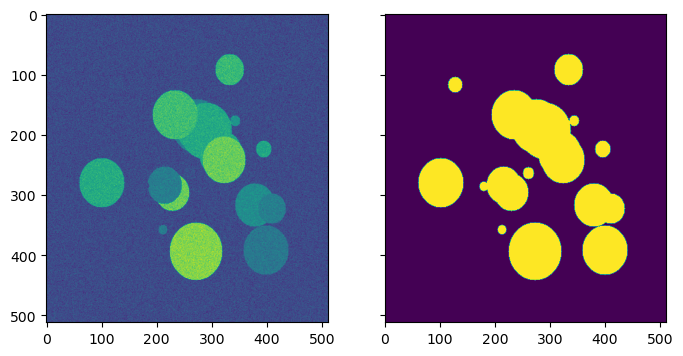

In [4]:
import matplotlib.pyplot as plt


nx = 512
ny = 512
generator = GrayScaleDataProvider(nx, ny, cnt=20)
x,y = generator(1)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x[0, ..., 0], aspect="auto")
ax[1].imshow(y[0, ..., 0], aspect="auto")

plt.show()

In [5]:
#создаем тестовые данные
n=700
nx = 512
ny = 512
generator = GrayScaleDataProvider(nx, ny, cnt=20)
images, masks = generator(n)


Split train/test/valid

In [6]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.3, random_state=42)
images_test, images_val, masks_test, masks_val = train_test_split(images_test, masks_test, test_size=0.5, random_state=42)

print(f"Training set shapes\nImages : {images_train.shape}\nMasks : {masks_train.shape}")
print(f"Test set shapes \nImages : {images_test.shape}\nMasks : {masks_test.shape}")
print(f"Val set shapes \nImages : {images_val.shape}\nMasks : {masks_val.shape}")

Training set shapes
Images : (490, 512, 512, 1)
Masks : (490, 512, 512, 1)
Test set shapes 
Images : (105, 512, 512, 1)
Masks : (105, 512, 512, 1)
Val set shapes 
Images : (105, 512, 512, 1)
Masks : (105, 512, 512, 1)


In [7]:
image_size =512

In [8]:
import torch.cuda
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device

'cpu'

In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, image_size=512):
        self.images = images
        self.masks = masks
        self.image_size = image_size

        # выполняем нормализацию
        self.transforms_imgs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # преобразовываем изображения в нужный формат
        image_resized = resize(image, (self.image_size, self.image_size), mode='constant', preserve_range=True)

        # преобразовываем маски в нужный формат
        mask_resized = resize(mask, (self.image_size, self.image_size), mode='constant', preserve_range=True)

        # Применяем трансформации
        image_tensor = self.transforms_imgs(image_resized / 255.)  # Нормализуем изображение
        mask_tensor = torch.Tensor(mask_resized).long().squeeze()  # Убираем лишнюю размерность

        return image_tensor, mask_tensor


In [11]:
def collate_fn(batch):
    ims, masks = list(zip(*batch))

    # Уже преобразовано в тензоры в SegmentationDataset, поэтому пропускаем ToTensor
    ims = torch.stack(ims).float().to(device)

    # Преобразуем маски в тензоры и убираем лишнюю размерность
    ce_masks = torch.stack([mask.squeeze() for mask in masks]).long().to(device)

    return ims, ce_masks


from torch.utils.data import DataLoader

# Создаем датасеты
train_ds = SegmentationDataset(images_train, masks_train)
test_ds = SegmentationDataset(images_test, masks_test)
val_ds = SegmentationDataset(images_val, masks_val)

# Создаем DataLoader для обучающей и тестовой выборки
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

[439, 696, 73]


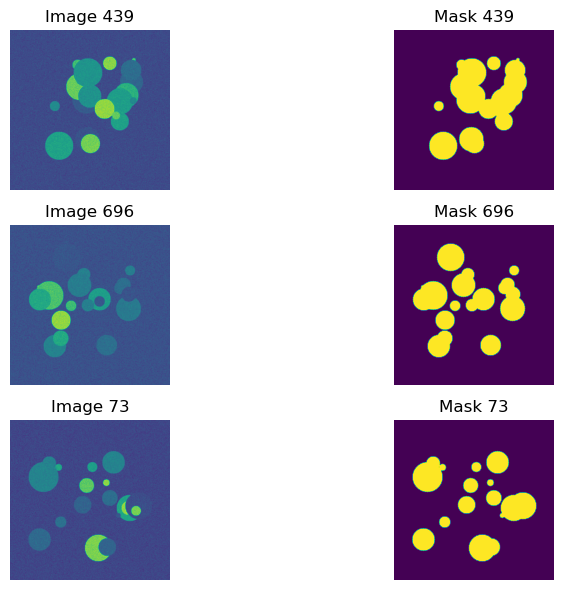

In [12]:
import random

# Функция для визуализации случайных изображений с масками
def visualize_random_images_with_masks(images, masks, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    # Выбираем случайные индексы для визуализации
    random_indices = random.sample(range(len(images)), num_samples)
    print(random_indices)

    for i, idx in enumerate(random_indices):
        image = images[idx]
        mask = masks[idx]
       
        # Ожидаем, что изображения имеют 3 канала
        ax_image = axes[i, 0]
        ax_mask = axes[i, 1]
                
        # Отображаем изображение
        ax_image.imshow(image)
        ax_image.set_title(f"Image {idx}")
        ax_image.axis('off')
        
        # Отображаем маску
        ax_mask.imshow(mask.squeeze())
        ax_mask.set_title(f"Mask {idx}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_images_with_masks(images, masks)


In [13]:
in_channels =1
num_classes = 2

In [14]:
# сверточный блок для левой части архитектуры

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [15]:
# апсемплинг блок для правой части архитектуры

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [16]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [18]:
#функция UnetLoss возвращает  потери и точность, показатели  для оптимизации модели и оценки ее производительности.
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

Функции для тренировки на батче данных и расчет метрик:

In [20]:
def train_batch(model, data, optimizer, criterion):
    model.train()  # модель в обучающем режиме
    ims, ce_masks = data  # Загружаем изображения и маски
    _masks = model(ims)  # Прогоняем изображения через модель
    optimizer.zero_grad()  # Обнуляем градиенты
    loss, acc = criterion(_masks, ce_masks)  # Рассчитываем лосс и точность
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    return loss.item(), acc.item()  # Возвращаем значения лосса и точности


@torch.no_grad()  # Отключаем градиенты для валидации
def test_batch(model, data, criterion):
    model.eval()  # Устанавливаем модель в режим инференса
    ims, masks = data  # Загружаем изображения и маски
    _masks = model(ims)  # Прогоняем изображения через модель
    loss, acc = criterion(_masks, masks)  # Рассчитываем лосс и точность
    return loss.item(), acc.item()  # Возвращаем значения лосса и точности

Этап тренировки:

In [22]:
from torch import optim

model = UNet(in_channels, num_classes).to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 1

In [23]:
import matplotlib.pyplot as plt

class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.metrics = {'trn_loss': [], 'test_loss': [],
                        'trn_acc': [], 'test_acc': []}
        self.steps = {key: [] for key in self.metrics}

    def record(self, pos, **kwargs):
        for key, value in kwargs.items():
            if key in self.metrics:
                self.metrics[key].append(value)
                self.steps[key].append(pos)

    def plot_epochs(self, metrics):
        for metric in metrics:
            plt.plot(self.steps[metric], self.metrics[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

In [24]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc)
        print(f'Train Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'train_loss: {loss:.4f}, train_acc: {acc:.4f}')

    N = len(test_dl)
    for bx, data in enumerate(test_dl):
        loss, acc = test_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, test_loss=loss, test_acc=acc)
        print(f'Test Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'test_loss: {loss:.4f}, test_acc: {acc:.4f}')

    print()

Train Epoch [1/1] Batch [1/123] train_loss: 0.6327, train_acc: 0.8298
Train Epoch [1/1] Batch [2/123] train_loss: 0.5880, train_acc: 0.8305
Train Epoch [1/1] Batch [3/123] train_loss: 0.5175, train_acc: 0.8040
Train Epoch [1/1] Batch [4/123] train_loss: 1.9188, train_acc: 0.8381
Train Epoch [1/1] Batch [5/123] train_loss: 0.5072, train_acc: 0.7973
Train Epoch [1/1] Batch [6/123] train_loss: 0.5129, train_acc: 0.8122
Train Epoch [1/1] Batch [7/123] train_loss: 0.5260, train_acc: 0.8197
Train Epoch [1/1] Batch [8/123] train_loss: 0.5158, train_acc: 0.8414
Train Epoch [1/1] Batch [9/123] train_loss: 0.5169, train_acc: 0.8302
Train Epoch [1/1] Batch [10/123] train_loss: 0.4990, train_acc: 0.8339
Train Epoch [1/1] Batch [11/123] train_loss: 0.4713, train_acc: 0.8420
Train Epoch [1/1] Batch [12/123] train_loss: 0.4436, train_acc: 0.8473
Train Epoch [1/1] Batch [13/123] train_loss: 0.4712, train_acc: 0.8214
Train Epoch [1/1] Batch [14/123] train_loss: 0.4584, train_acc: 0.8346
Train Epoch [1/

trn_loss: ~0.5
test_loss: ~ 0.47
trn_acc: ~ 0.8
test_acc: ~ 0.82
На train и test получили высокое качество модели. Test и train loss  одинаковые, это видно и на графике. Test и train acc: train acc во время обучения примерно на одном уровне 0.8-0.85, test acc - 0.74-0.9

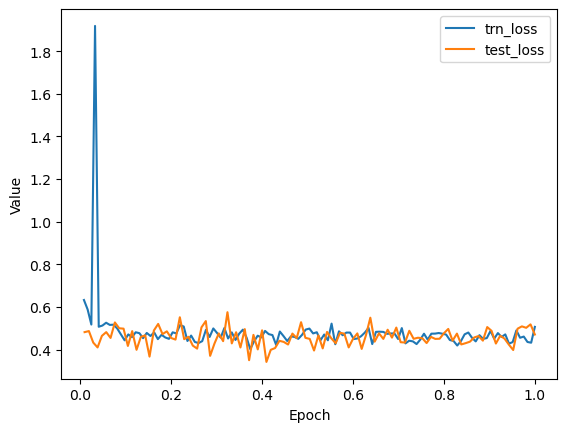

In [26]:
log.plot_epochs(['trn_loss','test_loss'])

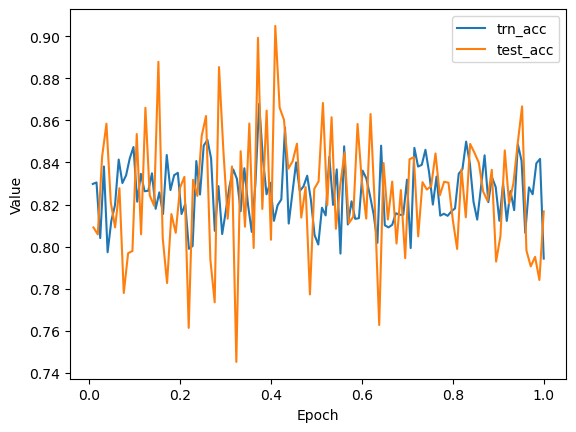

In [27]:
log.plot_epochs(['trn_acc','test_acc'])

In [49]:
def metrics(preds, targets):
    i = torch.logical_and(preds, targets).float().sum()
    u = torch.logical_or(preds,targets).float().sum()
    x = i/u
    iou = x.tolist()
    return  iou

In [51]:
@torch.no_grad()  # Отключаем градиенты для валидации
def valid_batch(model, data, criterion, metrics):
    model.eval()  # Устанавливаем модель в режим инференса
    ims, masks = data  # Загружаем изображения и маски
    _masks = model(ims)  # Прогоняем изображения через модель
    loss, acc = criterion(_masks, masks)  # Рассчитываем лосс и точность
    iou = metrics(_masks, masks)
    return loss.item(), acc.item(), iou # Возвращаем значения лосса и точности

In [53]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc, iou = valid_batch(model, data, criterion, metrics)
        log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc, val_iou=iou)
        print(f'Test Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'val_loss: {loss:.4f}, val_acc: {acc:.4f}, val_iou: {iou:.4f}')

    print()

Test Epoch [1/1] Batch [1/105] val_loss: 0.4914, val_acc: 0.8026, val_iou: 0.1974
Test Epoch [1/1] Batch [2/105] val_loss: 0.4162, val_acc: 0.8542, val_iou: 0.1458
Test Epoch [1/1] Batch [3/105] val_loss: 0.4378, val_acc: 0.8394, val_iou: 0.1606
Test Epoch [1/1] Batch [4/105] val_loss: 0.4628, val_acc: 0.8222, val_iou: 0.1778
Test Epoch [1/1] Batch [5/105] val_loss: 0.4812, val_acc: 0.8096, val_iou: 0.1904
Test Epoch [1/1] Batch [6/105] val_loss: 0.4057, val_acc: 0.8614, val_iou: 0.1386
Test Epoch [1/1] Batch [7/105] val_loss: 0.4898, val_acc: 0.8038, val_iou: 0.1962
Test Epoch [1/1] Batch [8/105] val_loss: 0.4337, val_acc: 0.8422, val_iou: 0.1578
Test Epoch [1/1] Batch [9/105] val_loss: 0.3564, val_acc: 0.8952, val_iou: 0.1048
Test Epoch [1/1] Batch [10/105] val_loss: 0.3948, val_acc: 0.8688, val_iou: 0.1312
Test Epoch [1/1] Batch [11/105] val_loss: 0.3854, val_acc: 0.8753, val_iou: 0.1247
Test Epoch [1/1] Batch [12/105] val_loss: 0.4048, val_acc: 0.8621, val_iou: 0.1379
Test Epoch [1

In [ ]:
На валидационной выборке loss  и acc примерно на одном уровне с train и test ~ 0.5 и 0.8. При этом iou ~ 0.2, значение низкое